# Weather Collection from NOAA

## The Imports

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime
from cdo_api_py import Client
from pprint import pprint

## Application 1: Weather Collection Tool

First, leveraging the `cdo_api_py`, we are scrapping official weather information from NOAA. We created a very flexible function that takes serveral parameters and find the data we need. This function allows you to find key weather information for anywhere around the world.

The `get_weather` function searches for weather stations around the world that provides the types of weather data based on the date range. Note that there could be more than one weather station in the defined region. Taking this into account, we grouped the data by date and averaged the temerpature and precipition collected from those weather stations. Lastly, we cleaned the cells and return a DataFrame that is useful for our purposes.

To use this function, you will need the following information ready at hand:
- **token**: A NOAA token is required to use this function. Please do not share your token with random people. You are able to grab a token from the following link: https://www.ncdc.noaa.gov/cdo-web/token
- **default limit**: The quantity of the data you want to scrape from the NOAA per request.
- **city_name**: The name of city. This should be a string.
- **north_lat**: The latitude of the north end of the region to search.
- **sounth_lat**: The latitude of the south end of the region to search.
- **east_long**: The longitude of the east end of the region to search.
- **west_long**: The longitude of the east end of the region to search.
- **start_year**: Start year.
- **start_month**: Start month.
- **start_day**: Start day.
- **end_year**: End year.
- **end_month**: End month.
- **end_day**: End day.

In [2]:
# Credit to Noah Christiansen for some major help in creating this function.
# Noah Christiansen: https://www.linkedin.com/in/noah-christiansen/

def get_weather(token, 
                default_limit, 
                city_name,
                north_lat,
                south_lat,
                east_long,
                west_long,
                start_year,
                start_month,
                start_day,
                end_year,
                end_month,
                end_day):
    
    print(f'Starting to scrap {city_name} weather data!')
    
    # Use token to activate the scrappping.
    # Token needs to be retrieved from NOAA.
    my_client = Client(token=token, 
                   default_units=None,
                   default_limit=default_limit)
    
    # Set the location from user input.
    extent = {
    'north' : north_lat,
    'south' : south_lat,
    'east' : east_long,
    'west' : west_long}

    # Set start date and end date from user input
    startdate = datetime(start_year, start_month, start_day)
    enddate = datetime(end_year, end_month, end_day)
    
    # Set the dataset to use from NOAA and the info we want.
    # Datatypes: Daily max temperature, daily min temperature, average wind speed and percipatation.
    datasetid = 'GHCND'
    datatypeid = ['TMAX', 'TMIN', 'PRCP']
    
    # Get all the staions from the defined range of areas.
    stations = my_client.find_stations(datasetid=datasetid,
                                    extent=extent,
                                    startdate=startdate,
                                    enddate=enddate,
                                    datatypeid=datatypeid,
                                    return_dataframe=True)
    
    # Create a DataFrame
    big_df = pd.DataFrame() 
    for rowid, station in stations.iterrows():
        station_data = my_client.get_data_by_station(datasetid=datasetid,
                                                     stationid=station['id'],
                                                     startdate=startdate,
                                                     enddate=enddate,
                                                     return_dataframe=True,
                                                     include_station_meta=True)
        big_df = pd.concat([big_df, station_data])
    
    # Some initial cleaning
    big_df['date'] = pd.to_datetime(big_df['date']).dt.date
    big_df = big_df.sort_values(by='date').reset_index()
    col_keep = ['station', 'name', 'date', 'PRCP', 'TMAX', 'TMIN', 'latitude', 'longitude']
    big_df = big_df[col_keep]
    
    # Create a super clean dataset to be combined with the tweets.
    clean_df = big_df.groupby('date').mean().round(2).reset_index()
    clean_df.insert(1, 'city', city_name.lower())
    clean_df['index'] = clean_df['date'].apply(str) + '-' + clean_df['city']
    
    # Create some additional cols to map numbers to categories.
    clean_df['PRCP_cat'] = pd.cut(x=clean_df['PRCP'], bins=[-np.inf, 0.1, 2.51, 10, 50.01, np.inf], labels=['dry', 'drizzle', 'rain', 'downpour', 'torrential'])
    clean_df['TMAX_cat'] = pd.cut(x=clean_df['TMAX'], bins=[-np.inf,0.01,100.00,210.00,328.00,np.inf], labels=['freezing','cold','warm','hot','scorching'])
    clean_df['TMIN_cat'] = pd.cut(x=clean_df['TMIN'], bins=[-np.inf,0.01,100.00,210.00,328.00,np.inf], labels=['freezing ||','cold ||','warm ||','hot ||','scorching ||'])
    
    return clean_df

## Data Collection & Cleaning: Houston and Manila

In [4]:
# Get cleaned DataFrame for Houston weather.
# Please use your personal token to reuse this code.

houston_df = get_weather(token='YourTokenHere',
                         default_limit=1000,
                         city_name='Houston',
                         north_lat=31.5928,
                         south_lat=30.9261,
                         east_long=-94.9577,
                         west_long=-95.7762,
                         start_year=2014,
                         start_month=1,
                         start_day=1,
                         end_year=2019,
                         end_month=11,
                         end_day=1)

Starting to scrap Houston weather data!
https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&startdate=2014-01-01&enddate=2019-11-01&extent=30.9261&extent=-95.7762&extent=31.5928&extent=-94.9577&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP&limit=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/stations/GHCND:USC00412114?limit=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2014-01-01&enddate=2015-01-01&stationid=GHCND:USC00412114&limit=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2014-01-01&enddate=2015-01-01&stationid=GHCND:USC00412114&limit=1000&offset=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2015-01-01&enddate=2016-01-01&stationid=GHCND:USC00412114&limit=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2015-01-01&enddate=2016-01-01&stationid=GHCND:USC00412114&limit=1000&offset=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&star

In [5]:
# Get cleaned DataFrame for Manila weather.
# Please use your personal token to reuse this code.

manila_df = get_weather(token='YourTokenHere',
                         default_limit=1000,
                         city_name='Manila',
                         north_lat=14.639181,
                         south_lat=14.553794,
                         east_long=121.027966,
                         west_long=120.941788,
                         start_year=2014,
                         start_month=1,
                         start_day=1,
                         end_year=2019,
                         end_month=11,
                         end_day=1)

Starting to scrap Manila weather data!
https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&startdate=2014-01-01&enddate=2019-11-01&extent=14.553794&extent=120.941788&extent=14.639181&extent=121.027966&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP&limit=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/stations/GHCND:RP000098430?limit=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2014-01-01&enddate=2015-01-01&stationid=GHCND:RP000098430&limit=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2014-01-01&enddate=2015-01-01&stationid=GHCND:RP000098430&limit=1000&offset=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2015-01-01&enddate=2016-01-01&stationid=GHCND:RP000098430&limit=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2015-01-01&enddate=2016-01-01&stationid=GHCND:RP000098430&limit=1000&offset=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHC

In [6]:
# Set the date to be our index and create a time series for houston_df
houston_df['date'] = pd.to_datetime(houston_df['date'])
houston_df.set_index('date', inplace=True)
houston_df.sort_index(inplace=True)

In [7]:
# Set the date to be our index and create a time series for manila_df
manila_df['date'] = pd.to_datetime(manila_df['date'])
manila_df.set_index('date', inplace=True)
manila_df.sort_index(inplace=True)

In [8]:
manila_df

,city,PRCP,TMAX,TMIN,latitude,longitude,index,PRCP_cat,TMAX_cat,TMIN_cat
date,,,,,,,,,,
2014-01-01,manila,NaN,320.0,192.0,14.63,121.02,2014-01-01-manila,NaN,hot,warm ||
2014-01-02,manila,NaN,316.0,NaN,14.63,121.02,2014-01-02-manila,NaN,hot,NaN
2014-01-03,manila,NaN,317.0,195.0,14.63,121.02,2014-01-03-manila,NaN,hot,warm ||
2014-01-04,manila,NaN,316.0,200.0,14.63,121.02,2014-01-04-manila,NaN,hot,warm ||
2014-01-05,manila,NaN,297.0,210.0,14.63,121.02,2014-01-05-manila,NaN,hot,warm ||
...,...,...,...,...,...,...,...,...,...,...
2019-10-28,manila,61.0,311.0,253.0,14.63,121.02,2019-10-28-manila,torrential,hot,hot ||
2019-10-29,manila,13.0,306.0,NaN,14.63,121.02,2019-10-29-manila,downpour,hot,NaN
2019-10-30,manila,10.0,307.0,240.0,14.63,121.02,2019-10-30-manila,rain,hot,hot ||


/Users/guoningli/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


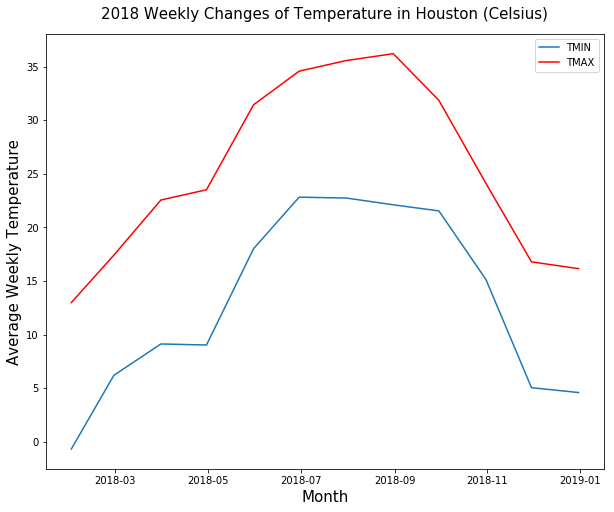

In [9]:
# EDA: Plot some simple graphs here.

plt.figure(figsize=(10,8))
plt.plot(houston_df['2018'].resample('M').mean()['TMIN']/10)
plt.plot(houston_df['2018'].resample('M').mean()['TMAX']/10, color='r')
plt.title('2018 Weekly Changes of Temperature in Houston (Celsius)', fontsize=15, pad=15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Average Weekly Temperature', fontsize=15)
plt.legend();

## Application 2: Weather Graphing Tool

The weather graphing tool is a natural extension from Application 1 to help users visualize long and short-term weather trend in a specific area or region. This tool is flexible and has the following features:

- **DataFrame (df)**: A pandas DataFrame is required to produce outcome from this tool. This DataFrame needs to be a time series generated from the DataFrame provided in Application 1.
- **Date range (start, end)**: The tool will adjust based on what the user wants to study. The model can be zoomed in to see weather trend in a particular week or month or it can be zoomed out to discover weather trend for years.
- **Frequency**: Takes in values to group the data. Options are 'A' for yearly, 'Q' for quarterly, 'M' for monthly and 'W' for weekly. 
- **Mode**: Users are able to flexibly choose to create a graph for precipitation (bar chart), temperature trend (line chart) or both. Acceptable values are 'p' for precipitation, 't' for temperature and 'both' for a combo graph.
- **Dark mode**: To fit different presentation decks, the user is able to specify a dark mode for the charts to fit dark-themed slides.

In [14]:
def weather_plot(df,
                 city_name: str,
                 start: str=None,
                 end: str=None,
                 freq: str='W',
                 mode: str="both",
                 dark_theme: bool=False):
    
    # Create a duration dictionary to map frequenct to actual words.
    duration_dict = {
        'W' : 'Weekly',
        'M' : 'Monthly',
        'Q' : 'Quarterly',
        'A' : 'Yearly'
    }
    
    # First, get the subset of data from the defined start date to the end date.
    df = df.loc[start : end]
    
    if dark_theme:
        plt.style.use('dark_background')
        
    
    # Scenario 1: Plot both average temperature and aggregated percipation on one graph.
    if mode == 'both':
        # Let's first build temperature graph.
        fig, ax1 = plt.subplots(figsize = (20,10))
        ax1.set_xlabel(f'Time ({duration_dict[freq]})', fontsize=30)
        ax1.set_ylabel(f'Average {duration_dict[freq]} Temperature (Celsius)', fontsize=30)
        ax1.plot(df.resample(freq).mean()['TMAX']/10, color='orange')
        ax1.plot(df.resample(freq).mean()['TMIN']/10, color='cyan')
        ax1.tick_params(axis='both', labelsize=20)
        ax1.legend(['TMAX', 'TMIN'], fontsize=15)

        # Next up, precipitation on the other y-axis but sharing the x-axis.
        ax2 = ax1.twinx()
        ax2.set_ylabel('Precipitation (Period Aggregated)', color='cadetblue', fontsize=30)
        ax2.bar(df.resample(freq).sum()['PRCP'].index, 
            list(df.resample(freq).sum()['PRCP']),
            align='center',
            width=1.2)
        ax2.tick_params(axis='y', labelcolor='cadetblue', labelsize=20)

        # Set the title.
        plt.title(f'{duration_dict[freq]} Changes of Temperature and Precipitation in {city_name}', fontsize=40, pad=15)

        # Next, set up the year dividers.
        # First, we will need to create a list of all the years in our data.
        year_list = list(set([df.index[i].to_pydatetime().year for i in range(df.shape[0])]))
        if len(year_list) > 1:
            year_list.sort()
            for y in year_list[1:]:
                plt.axvline(x=datetime(y,1,1), color='r', linestyle='--', alpha=0.8);      
        
        
        
    # Sceanario 2: Precipitation only, if the user selects 'p'.
    elif mode == 'p':
        
        # Create the bar chart.
        plt.figure(figsize=(20, 15))
        plt.bar(df.resample(freq).sum()['PRCP'].index,
            list(df.resample(freq).sum()['PRCP']),
            align='center',
            width=1.2)
        
        # Set the tick parameters and labels and stuff.
        plt.tick_params(axis='both', labelsize=20)
        plt.xlabel(f'Time ({duration_dict[freq]})', fontsize=30)
        plt.ylabel('Precipitation (Period Aggregated)', fontsize=30)
        plt.title(f'{duration_dict[freq]} Accumulation of Precipitation in {city_name}', fontsize=40, pad=15)
        year_list = list(set([df.index[i].to_pydatetime().year for i in range(df.shape[0])]))
        
        # Create the verticle lines to seperate the years.
        if len(year_list) > 1:
            year_list.sort()
            for y in year_list[1:]:
                plt.axvline(x=datetime(y,1,1), color='r', linestyle='--', alpha=0.8);
                
    
    
    # Scenario 3: Temperature only, if the user selects 't'.
    elif mode == 't':
        
        # Create the max and min temperature lines.
        plt.figure(figsize=(20, 15))
        plt.plot(df.resample(freq).mean()['TMAX']/10, color='orange')
        plt.plot(df.resample(freq).mean()['TMIN']/10, color='blue')
        
        # Set the tick parameters and labels and stuff.
        plt.tick_params(axis='both', labelsize=20)
        plt.xlabel(f'Time ({duration_dict[freq]})', fontsize=30)
        plt.ylabel(f'Average {duration_dict[freq]} Temperature (Celsius)', fontsize=20)
        plt.title(f'{duration_dict[freq]} Changes of Temerpature in {city_name}', fontsize=40, pad=15)
        year_list = list(set([df.index[i].to_pydatetime().year for i in range(df.shape[0])]))
        
        # Create the verticle lines to seperate the years.
        if len(year_list) > 1:
            year_list.sort()
            for y in year_list[1:]:
                plt.axvline(x=datetime(y,1,1), color='r', linestyle='--', alpha=0.8);

    
    
    # Catch all sceanrio, if the user did something wrong.
    else: print('Please select a correct mode.\nEneter t for temerature graph.\nEnter p for precipitation graph.\nEnter both for a combined graph.')

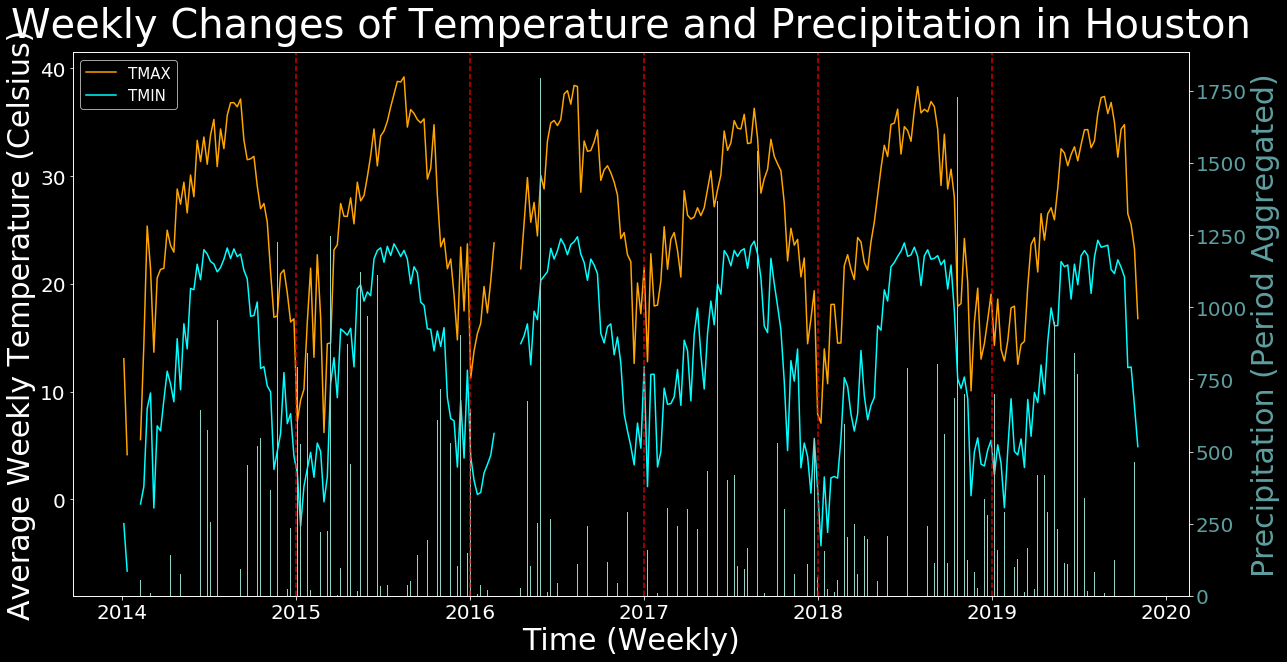

In [15]:
# Plot a combo weekly weather chart for Houston weather over the past 5 years.

weather_plot(houston_df, 
             city_name='Houston',
             mode='both',
             dark_theme=True)

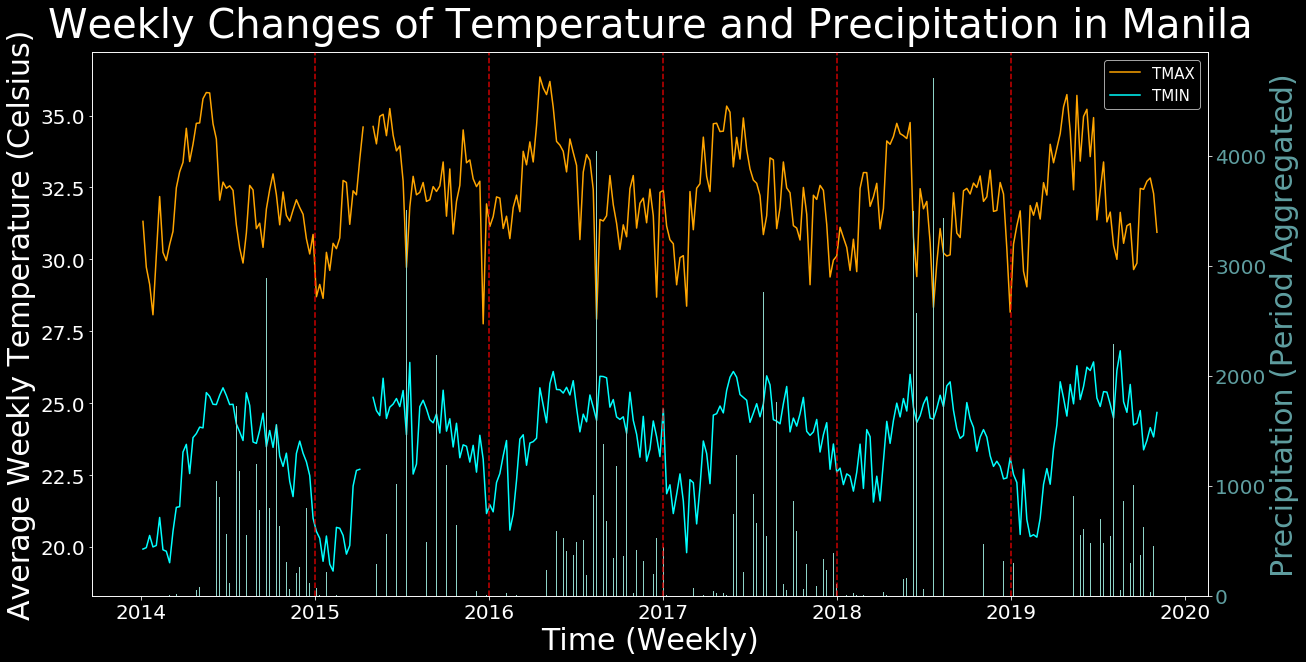

In [16]:
# Plot a combo weekly weather chart for Manila weather over the past 5 years.

weather_plot(manila_df, 
             city_name='Manila', 
             mode='both',
             dark_theme=True)

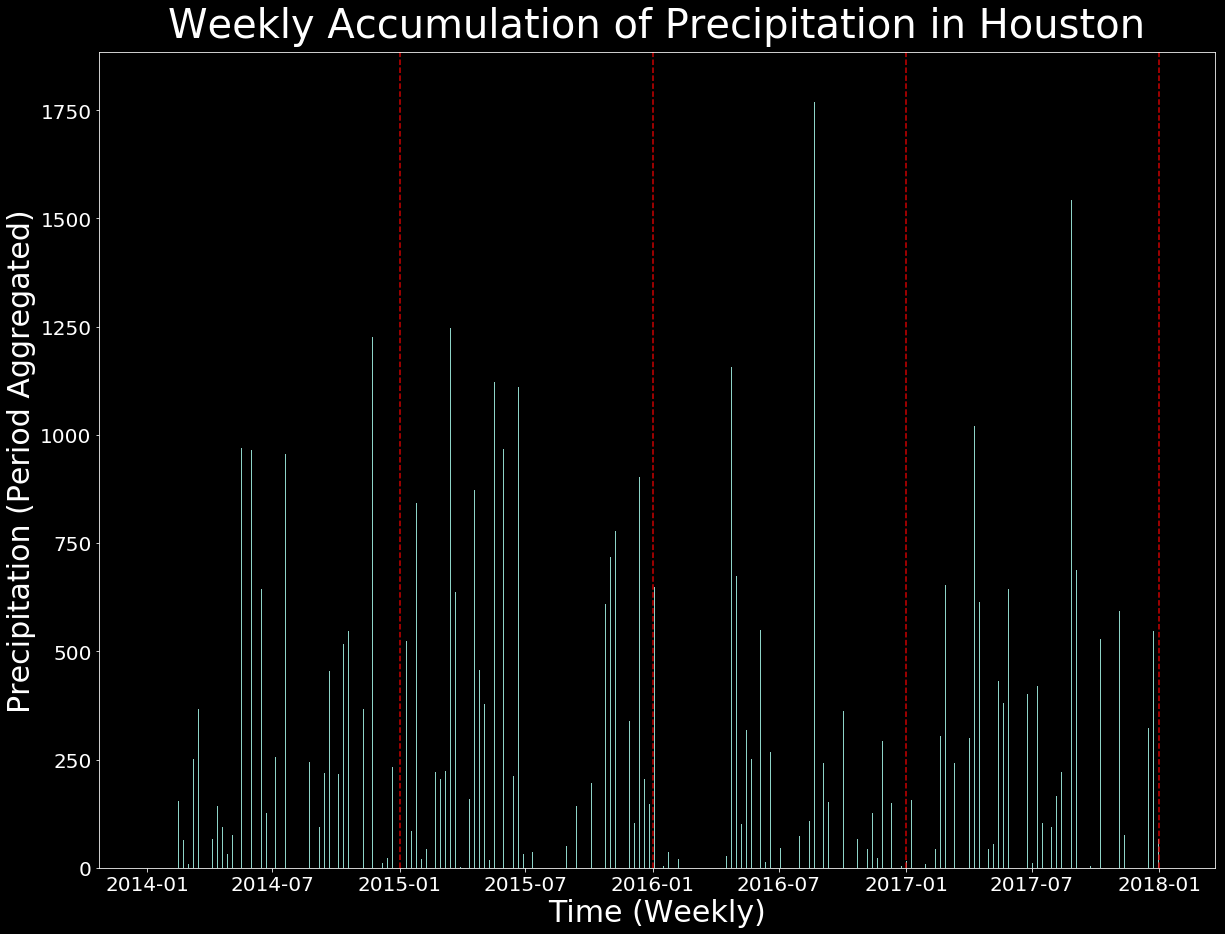

In [19]:
# Plot a weekly precipitation chart chart for Houston from 2014-1-1 to 2018-1-1.

weather_plot(houston_df, 
             city_name='Houston',
             start='2014-1-1',
             end='2018-1-1',
             mode='p',
             dark_theme=True)

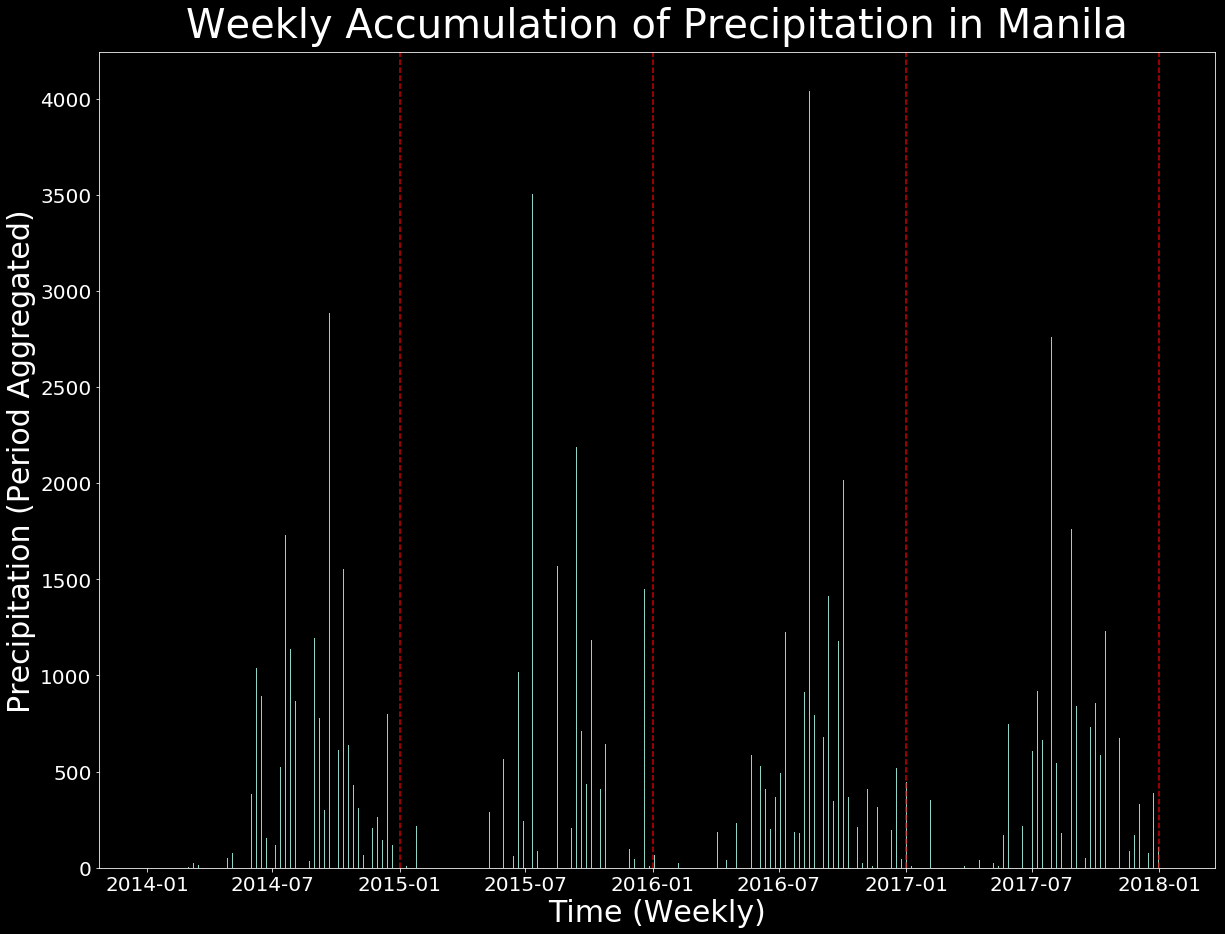

In [20]:
# Plot a weekly precipitation chart chart for Manila from 2014-1-1 to 2018-1-1.

weather_plot(manila_df, 
             city_name='Manila',
             start='2014-1-1',
             end='2018-1-1',
             mode='p',
             dark_theme=True)